Columns in accel100.csv: ['Date', 'HostTimestamp', 'NodeName', 'NodeTimestamp', 'RawData', 'X (mg)', 'Y (mg)', 'Z (mg)']
Columns in gyro100.csv: ['Date', 'HostTimestamp', 'NodeName', 'NodeTimestamp', 'RawData', 'X (dps)', 'Y (dps)', 'Z (dps)']
Columns in mag100.csv: ['Date', 'HostTimestamp', 'NodeName', 'NodeTimestamp', 'RawData', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']


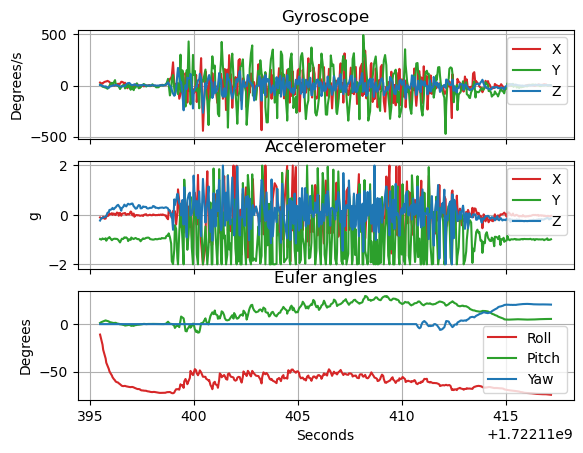

In [56]:
#orientation not adjusted

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imufusion
import sys

# Function to parse the date and time from the string
def parse_timestamp(date_str):
    return pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S.%f').timestamp()

# Function to read and process data files
def read_sensor_data(filename, sensor_type):
    # Read the file, skipping the metadata lines
    data = pd.read_csv(filename, skiprows=4)
    
    # Print the columns to verify the actual column names
    print(f"Columns in {filename}: {data.columns.tolist()}")
    
    # Extract relevant columns
    if sensor_type == 'accelerometer':
        relevant_columns = ['Date', 'X (mg)', 'Y (mg)', 'Z (mg)']
    elif sensor_type == 'magnetometer':
        relevant_columns = ['Date', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']
    elif sensor_type == 'gyroscope':
        relevant_columns = ['Date', 'X (dps)', 'Y (dps)', 'Z (dps)']
    else:
        raise ValueError(f"Unknown sensor type: {sensor_type}")

    # Filter relevant columns
    data = data[relevant_columns]
    
    # Rename columns to a consistent format
    data.columns = ['Date', 'X', 'Y', 'Z']
    
    # Convert Date to timestamp
    data['Timestamp'] = data['Date'].apply(parse_timestamp)
    
    # Remove duplicates by averaging the values if there are multiple entries for the same timestamp
    data = data.groupby('Timestamp').agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean'}).reset_index()
    
    return data

# Read and process all sensor data files
accel_data = read_sensor_data('accel100.csv', 'accelerometer')
gyro_data = read_sensor_data('gyro100.csv', 'gyroscope')
mag_data = read_sensor_data('mag100.csv', 'magnetometer')

# Align timestamps
timestamps = np.intersect1d(accel_data['Timestamp'], gyro_data['Timestamp'])
timestamps = np.intersect1d(timestamps, mag_data['Timestamp'])

def align_data(df, timestamps):
    df = df.set_index('Timestamp')
    df = df.reindex(timestamps).interpolate(method='linear').bfill().reset_index()
    return df

accel_data_aligned = align_data(accel_data, timestamps)
gyro_data_aligned = align_data(gyro_data, timestamps)
mag_data_aligned = align_data(mag_data, timestamps)

# Extract sensor data
timestamp = accel_data_aligned['Timestamp'].values
accelerometer = accel_data_aligned[['X', 'Y', 'Z']].values / 1000  # Convert mg to g
gyroscope = gyro_data_aligned[['X', 'Y', 'Z']].values

# Plot sensor data
_, axes = plt.subplots(nrows=3, sharex=True)

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Z")
axes[0].set_title("Gyroscope")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Z")
axes[1].set_title("Accelerometer")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

# Process sensor data
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], 1 / 100)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

# Plot Euler angles
axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_title("Euler angles")
axes[2].set_xlabel("Seconds")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

plt.show(block="no_block" not in sys.argv)  # don't block when script run by CI


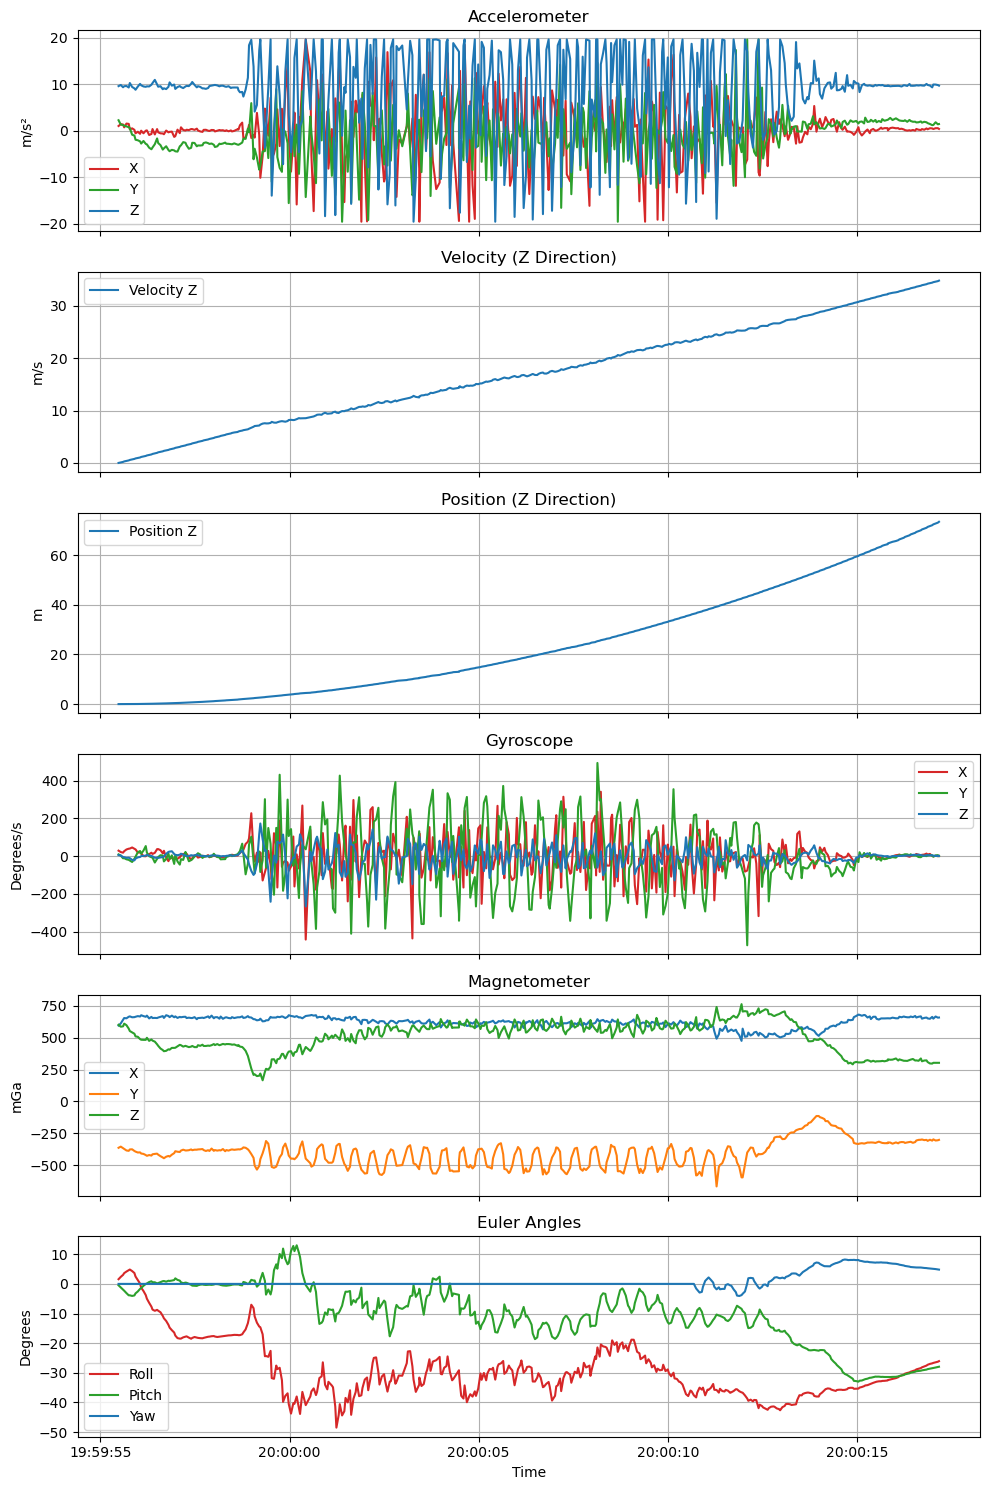

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import imufusion
import sys

# Function to parse the date and time from the string
def parse_timestamp(date_str):
    return pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S.%f').timestamp()

# Function to read and process data files
def read_sensor_data(filename, sensor_type):
    data = pd.read_csv(filename, skiprows=4)
    
    # Extract relevant columns
    if sensor_type == 'accelerometer':
        relevant_columns = ['Date', 'X (mg)', 'Y (mg)', 'Z (mg)']
    elif sensor_type == 'magnetometer':
        relevant_columns = ['Date', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']
    elif sensor_type == 'gyroscope':
        relevant_columns = ['Date', 'X (dps)', 'Y (dps)', 'Z (dps)']
    else:
        raise ValueError(f"Unknown sensor type: {sensor_type}")

    # Filter relevant columns
    data = data[relevant_columns]
    
    # Rename columns to a consistent format
    data.columns = ['Date', 'X', 'Y', 'Z']
    
    # Convert Date to timestamp
    data['Timestamp'] = data['Date'].apply(parse_timestamp)
    
    # Remove duplicates by averaging the values if there are multiple entries for the same timestamp
    data = data.groupby('Timestamp').agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean'}).reset_index()
    
    return data

# Read and process all sensor data files
accel_data = read_sensor_data('accel100.csv', 'accelerometer')
gyro_data = read_sensor_data('gyro100.csv', 'gyroscope')
mag_data = read_sensor_data('mag100.csv', 'magnetometer')

# Align timestamps
timestamps = np.intersect1d(accel_data['Timestamp'], gyro_data['Timestamp'])
timestamps = np.intersect1d(timestamps, mag_data['Timestamp'])

def align_data(df, timestamps):
    df = df.set_index('Timestamp')
    df = df.reindex(timestamps).interpolate(method='linear').bfill().reset_index()
    return df

accel_data_aligned = align_data(accel_data, timestamps)
gyro_data_aligned = align_data(gyro_data, timestamps)
mag_data_aligned = align_data(mag_data, timestamps)

# Extract sensor data
timestamp = accel_data_aligned['Timestamp'].values
accelerometer = accel_data_aligned[['X', 'Y', 'Z']].values / 1000  # Convert mg to g
gyroscope = gyro_data_aligned[['X', 'Y', 'Z']].values

# Define the combined rotation matrix
def combined_rotation_matrix():
    # 90 degrees around X-axis
    R_x_90 = np.array([
        [1, 0, 0],
        [0, 0, 1],
        [0, -1, 0]
    ])
    
    # 180 degrees around Z-axis
    R_z_180 = np.array([
        [-1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])
    
    # Combined rotation
    return R_z_180 @ R_x_90

R = combined_rotation_matrix()

# Rotate accelerometer data
accelerometer_rotated = (R @ accelerometer.T).T

# Convert acceleration from g to m/s² (1 g ≈ 9.81 m/s²)
accelerometer_rotated *= 9.81

# Dead reckoning calculations
def dead_reckoning(accel_data, delta_t):
    # Initialize arrays for velocity and position
    velocity = np.zeros_like(accel_data)
    position = np.zeros_like(accel_data)
    
    # Perform numerical integration
    for i in range(1, len(accel_data)):
        velocity[i] = velocity[i-1] + accel_data[i-1] * delta_t
        position[i] = position[i-1] + velocity[i-1] * delta_t
    
    return velocity, position

# Assuming a sample rate of 100 Hz
delta_t = 1 / 100

# Compute velocity and position
velocity = np.zeros((len(timestamp), 3))
position = np.zeros((len(timestamp), 3))
velocity[:, 2], position[:, 2] = dead_reckoning(accelerometer_rotated[:, 2], delta_t)

# Convert timestamps to datetime for plotting
timestamp_datetime = pd.to_datetime(timestamp, unit='s')

# Plot sensor data
fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(10, 15))

# Plot Accelerometer Data
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 0], "tab:red", label="X")
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 2], "tab:blue", label="Z")
axes[0].set_title("Accelerometer")
axes[0].set_ylabel("m/s²")
axes[0].grid()
axes[0].legend()

# Plot Velocity Data
axes[1].plot(timestamp_datetime, velocity[:, 2], "tab:blue", label="Velocity Z")
axes[1].set_title("Velocity (Z Direction)")
axes[1].set_ylabel("m/s")
axes[1].grid()
axes[1].legend()

# Plot Position Data
axes[2].plot(timestamp_datetime, position[:, 2], "tab:blue", label="Position Z")
axes[2].set_title("Position (Z Direction)")
axes[2].set_ylabel("m")
axes[2].grid()
axes[2].legend()

# Plot Gyroscope Data
axes[3].plot(timestamp_datetime, gyroscope[:, 0], "tab:red", label="X")
axes[3].plot(timestamp_datetime, gyroscope[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp_datetime, gyroscope[:, 2], "tab:blue", label="Z")
axes[3].set_title("Gyroscope")
axes[3].set_ylabel("Degrees/s")
axes[3].grid()
axes[3].legend()

# Plot Magnetometer Data
axes[4].plot(timestamp_datetime, mag_data_aligned[['X', 'Y', 'Z']].values, label=['X', 'Y', 'Z'])
axes[4].set_title("Magnetometer")
axes[4].set_ylabel("mGa")
axes[4].grid()
axes[4].legend()

# Plot Euler angles
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer_rotated[index], 1 / 100)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

axes[5].plot(timestamp_datetime, euler[:, 0], "tab:red", label="Roll")
axes[5].plot(timestamp_datetime, euler[:, 1], "tab:green", label="Pitch")
axes[5].plot(timestamp_datetime, euler[:, 2], "tab:blue", label="Yaw")
axes[5].set_title("Euler Angles")
axes[5].set_xlabel("Time")
axes[5].set_ylabel("Degrees")
axes[5].grid()
axes[5].legend()

# Set x-axis format
axes[5].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show(block="no_block" not in sys.argv)  # don't block when script run by CI


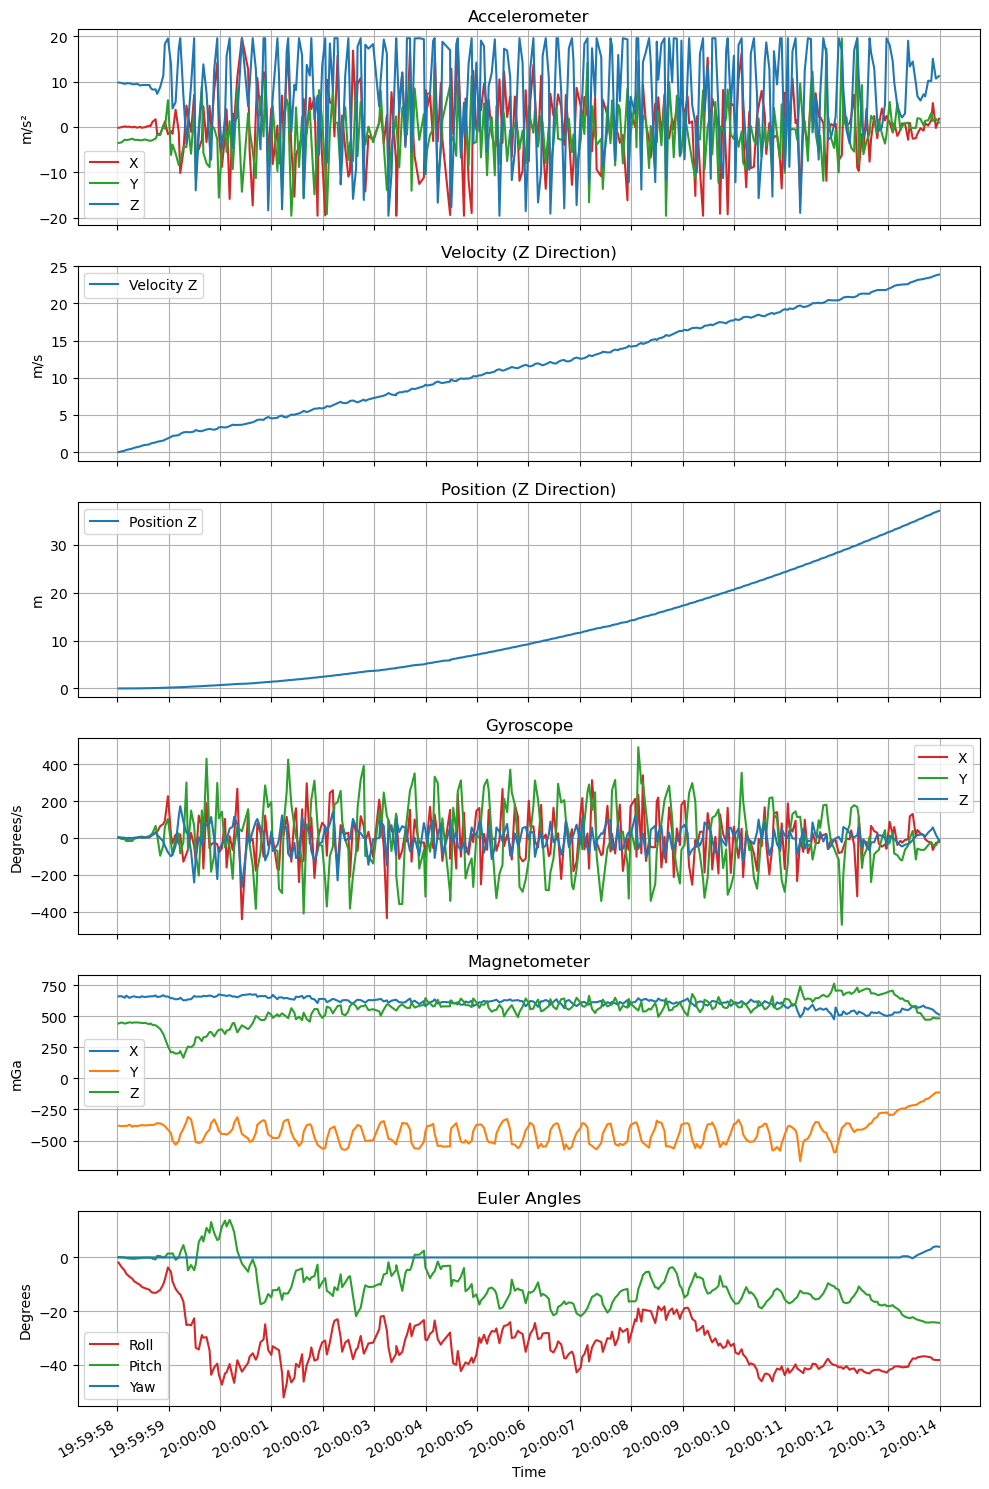

In [70]:
#filtering by date time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import imufusion
import sys

# Function to parse the date and time from the string
def parse_timestamp(date_str):
    return pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S.%f').timestamp()

# Function to read and process data files
def read_sensor_data(filename, sensor_type):
    data = pd.read_csv(filename, skiprows=4)
    
    # Extract relevant columns
    if sensor_type == 'accelerometer':
        relevant_columns = ['Date', 'X (mg)', 'Y (mg)', 'Z (mg)']
    elif sensor_type == 'magnetometer':
        relevant_columns = ['Date', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']
    elif sensor_type == 'gyroscope':
        relevant_columns = ['Date', 'X (dps)', 'Y (dps)', 'Z (dps)']
    else:
        raise ValueError(f"Unknown sensor type: {sensor_type}")

    # Filter relevant columns
    data = data[relevant_columns]
    
    # Rename columns to a consistent format
    data.columns = ['Date', 'X', 'Y', 'Z']
    
    # Convert Date to timestamp
    data['Timestamp'] = data['Date'].apply(parse_timestamp)
    
    # Remove duplicates by averaging the values if there are multiple entries for the same timestamp
    data = data.groupby('Timestamp').agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean'}).reset_index()
    
    return data

# Function to filter data based on a time range
def filter_data_by_time(df, start_time, end_time):
    df = df[(df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time)]
    return df

# Parameters for filtering
start_time_str = '2024-07-27 19:59:58'
end_time_str = '2024-07-27 20:00:14'

# Convert start and end times to timestamps
start_time = pd.to_datetime(start_time_str).timestamp()
end_time = pd.to_datetime(end_time_str).timestamp()

# Read and process all sensor data files
accel_data = read_sensor_data('accel100.csv', 'accelerometer')
gyro_data = read_sensor_data('gyro100.csv', 'gyroscope')
mag_data = read_sensor_data('mag100.csv', 'magnetometer')

# Filter data based on the specified time range
accel_data_filtered = filter_data_by_time(accel_data, start_time, end_time)
gyro_data_filtered = filter_data_by_time(gyro_data, start_time, end_time)
mag_data_filtered = filter_data_by_time(mag_data, start_time, end_time)

# Align timestamps
timestamps = np.intersect1d(accel_data_filtered['Timestamp'], gyro_data_filtered['Timestamp'])
timestamps = np.intersect1d(timestamps, mag_data_filtered['Timestamp'])

def align_data(df, timestamps):
    df = df.set_index('Timestamp')
    df = df.reindex(timestamps).interpolate(method='linear').bfill().reset_index()
    return df

accel_data_aligned = align_data(accel_data_filtered, timestamps)
gyro_data_aligned = align_data(gyro_data_filtered, timestamps)
mag_data_aligned = align_data(mag_data_filtered, timestamps)

# Extract sensor data
timestamp = accel_data_aligned['Timestamp'].values
accelerometer = accel_data_aligned[['X', 'Y', 'Z']].values / 1000  # Convert mg to g
gyroscope = gyro_data_aligned[['X', 'Y', 'Z']].values

# Define the combined rotation matrix
def combined_rotation_matrix():
    # 90 degrees around X-axis
    R_x_90 = np.array([
        [1, 0, 0],
        [0, 0, 1],
        [0, -1, 0]
    ])
    
    # 180 degrees around Z-axis
    R_z_180 = np.array([
        [-1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])
    
    # Combined rotation
    return R_z_180 @ R_x_90

R = combined_rotation_matrix()

# Rotate accelerometer data
accelerometer_rotated = (R @ accelerometer.T).T

# Convert acceleration from g to m/s² (1 g ≈ 9.81 m/s²)
accelerometer_rotated *= 9.81

# Dead reckoning calculations
def dead_reckoning(accel_data, delta_t):
    # Initialize arrays for velocity and position
    velocity = np.zeros_like(accel_data)
    position = np.zeros_like(accel_data)
    
    # Perform numerical integration
    for i in range(1, len(accel_data)):
        velocity[i] = velocity[i-1] + accel_data[i-1] * delta_t
        position[i] = position[i-1] + velocity[i-1] * delta_t
    
    return velocity, position

# Assuming a sample rate of 100 Hz
delta_t = 1 / 100

# Compute velocity and position
velocity = np.zeros((len(timestamp), 3))
position = np.zeros((len(timestamp), 3))
velocity[:, 2], position[:, 2] = dead_reckoning(accelerometer_rotated[:, 2], delta_t)

# Convert timestamps to datetime for plotting
timestamp_datetime = pd.to_datetime(timestamp, unit='s')

# Plot sensor data
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15), sharex=True)

# Plot Accelerometer Data
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 0], "tab:red", label="X")
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 2], "tab:blue", label="Z")
axes[0].set_title("Accelerometer")
axes[0].set_ylabel("m/s²")
axes[0].grid()
axes[0].legend()

# Plot Velocity Data
axes[1].plot(timestamp_datetime, velocity[:, 2], "tab:blue", label="Velocity Z")
axes[1].set_title("Velocity (Z Direction)")
axes[1].set_ylabel("m/s")
axes[1].grid()
axes[1].legend()

# Plot Position Data
axes[2].plot(timestamp_datetime, position[:, 2], "tab:blue", label="Position Z")
axes[2].set_title("Position (Z Direction)")
axes[2].set_ylabel("m")
axes[2].grid()
axes[2].legend()

# Plot Gyroscope Data
axes[3].plot(timestamp_datetime, gyroscope[:, 0], "tab:red", label="X")
axes[3].plot(timestamp_datetime, gyroscope[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp_datetime, gyroscope[:, 2], "tab:blue", label="Z")
axes[3].set_title("Gyroscope")
axes[3].set_ylabel("Degrees/s")
axes[3].grid()
axes[3].legend()

# Plot Magnetometer Data
axes[4].plot(timestamp_datetime, mag_data_aligned[['X', 'Y', 'Z']].values, label=['X', 'Y', 'Z'])
axes[4].set_title("Magnetometer")
axes[4].set_ylabel("mGa")
axes[4].grid()
axes[4].legend()

# Plot Euler angles
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer_rotated[index], 1 / 100)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

axes[5].plot(timestamp_datetime, euler[:, 0], "tab:red", label="Roll")
axes[5].plot(timestamp_datetime, euler[:, 1], "tab:green", label="Pitch")
axes[5].plot(timestamp_datetime, euler[:, 2], "tab:blue", label="Yaw")
axes[5].set_title("Euler Angles")
axes[5].set_xlabel("Time")
axes[5].set_ylabel("Degrees")
axes[5].grid()
axes[5].legend()

# Set x-axis format for all subplots
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(mdates.SecondLocator())

# Auto-format date labels
fig.autofmt_xdate()

plt.tight_layout()
plt.show(block="no_block" not in sys.argv)  # don't block when script run by CI


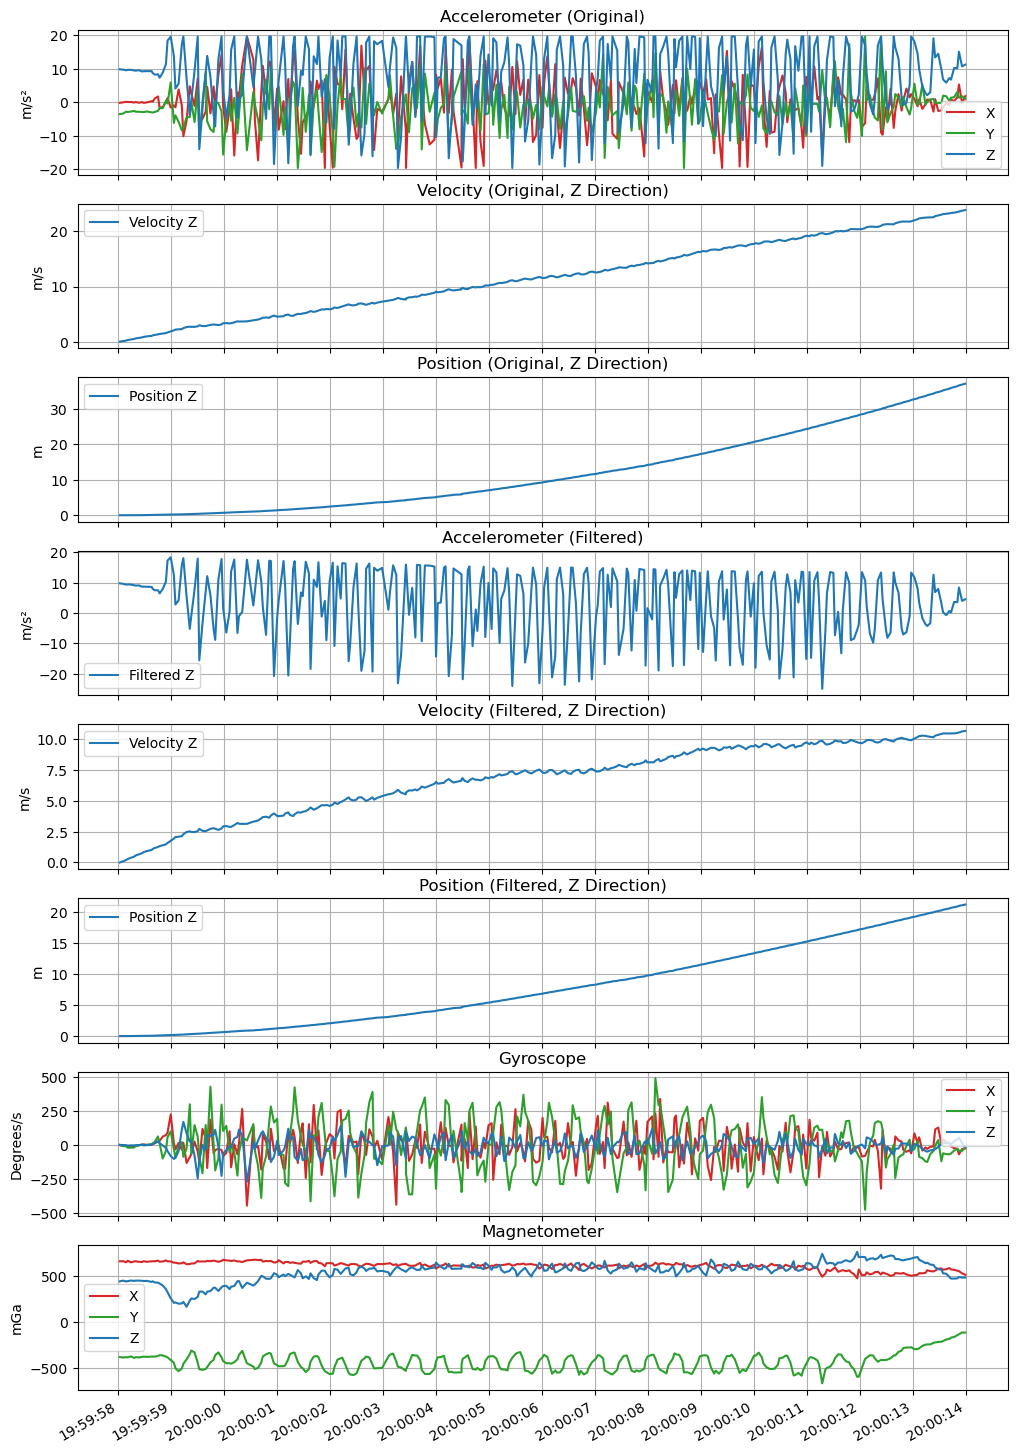

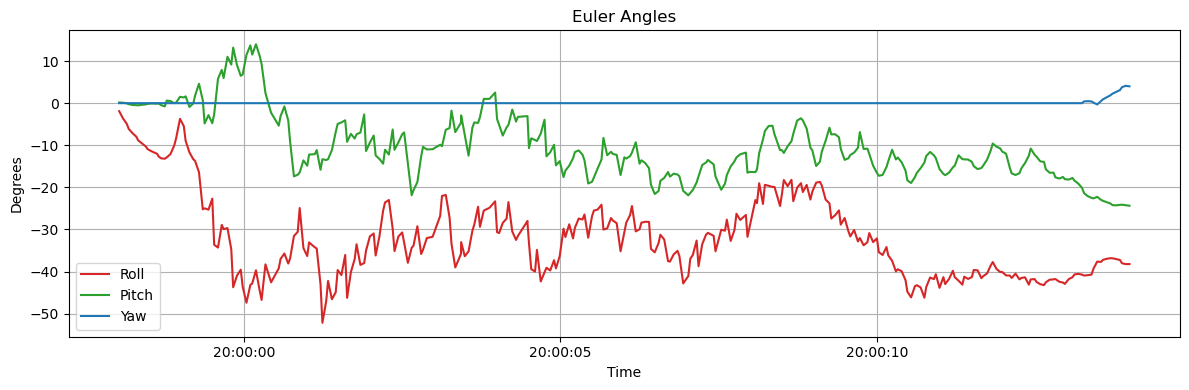

In [89]:
#high pass and non high pass data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import imufusion
import sys

# Define a high-pass filter class
class HighPassFilter:
    def __init__(self, cutoff_freq, sample_rate):
        self.cutoff_freq = cutoff_freq
        self.sample_rate = sample_rate
        self.alpha = self.calculate_alpha()
        self.prev_output = None
        self.prev_input = None

    def calculate_alpha(self):
        dt = 1.0 / self.sample_rate
        RC = 1.0 / (2 * np.pi * self.cutoff_freq)
        return RC / (RC + dt)

    def apply(self, data):
        if self.prev_output is None:
            self.prev_output = data
            self.prev_input = data
        else:
            self.prev_output = self.alpha * (self.prev_output + data - self.prev_input)
            self.prev_input = data
        return self.prev_output

# Function to parse the date and time from the string
def parse_timestamp(date_str):
    return pd.to_datetime(date_str, format='%d/%m/%Y %H:%M:%S.%f').timestamp()

# Function to read and process data files
def read_sensor_data(filename, sensor_type):
    data = pd.read_csv(filename, skiprows=4)
    
    # Extract relevant columns
    if sensor_type == 'accelerometer':
        relevant_columns = ['Date', 'X (mg)', 'Y (mg)', 'Z (mg)']
    elif sensor_type == 'magnetometer':
        relevant_columns = ['Date', 'X (mGa)', 'Y (mGa)', 'Z (mGa)']
    elif sensor_type == 'gyroscope':
        relevant_columns = ['Date', 'X (dps)', 'Y (dps)', 'Z (dps)']
    else:
        raise ValueError(f"Unknown sensor type: {sensor_type}")

    # Filter relevant columns
    data = data[relevant_columns]
    
    # Rename columns to a consistent format
    data.columns = ['Date', 'X', 'Y', 'Z']
    
    # Convert Date to timestamp
    data['Timestamp'] = data['Date'].apply(parse_timestamp)
    
    # Remove duplicates by averaging the values if there are multiple entries for the same timestamp
    data = data.groupby('Timestamp').agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean'}).reset_index()
    
    return data

# Function to filter data based on a time range
def filter_data_by_time(df, start_time, end_time):
    df = df[(df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time)]
    return df

# Parameters for filtering
start_time_str = '2024-07-27 19:59:58'
end_time_str = '2024-07-27 20:00:14'

# Convert start and end times to timestamps
start_time = pd.to_datetime(start_time_str).timestamp()
end_time = pd.to_datetime(end_time_str).timestamp()

# Read and process all sensor data files
accel_data = read_sensor_data('accel100.csv', 'accelerometer')
gyro_data = read_sensor_data('gyro100.csv', 'gyroscope')
mag_data = read_sensor_data('mag100.csv', 'magnetometer')

# Filter data based on the specified time range
accel_data_filtered = filter_data_by_time(accel_data, start_time, end_time)
gyro_data_filtered = filter_data_by_time(gyro_data, start_time, end_time)
mag_data_filtered = filter_data_by_time(mag_data, start_time, end_time)

# Align timestamps
timestamps = np.intersect1d(accel_data_filtered['Timestamp'], gyro_data_filtered['Timestamp'])
timestamps = np.intersect1d(timestamps, mag_data_filtered['Timestamp'])

def align_data(df, timestamps):
    df = df.set_index('Timestamp')
    df = df.reindex(timestamps).interpolate(method='linear').bfill().reset_index()
    return df

accel_data_aligned = align_data(accel_data_filtered, timestamps)
gyro_data_aligned = align_data(gyro_data_filtered, timestamps)
mag_data_aligned = align_data(mag_data_filtered, timestamps)

# Extract sensor data
timestamp = accel_data_aligned['Timestamp'].values
accelerometer = accel_data_aligned[['X', 'Y', 'Z']].values / 1000  # Convert mg to g
gyroscope = gyro_data_aligned[['X', 'Y', 'Z']].values
magnetometer = mag_data_aligned[['X', 'Y', 'Z']].values

# Define the combined rotation matrix
def combined_rotation_matrix():
    # 90 degrees around X-axis
    R_x_90 = np.array([
        [1, 0, 0],
        [0, 0, 1],
        [0, -1, 0]
    ])
    
    # 180 degrees around Z-axis
    R_z_180 = np.array([
        [-1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])
    
    # Combined rotation
    return R_z_180 @ R_x_90

R = combined_rotation_matrix()

# Rotate accelerometer data
accelerometer_rotated = (R @ accelerometer.T).T

# Convert acceleration from g to m/s² (1 g ≈ 9.81 m/s²)
accelerometer_rotated *= 9.81

# Initialize the high-pass filter
sample_rate = 100  # Sample rate in Hz
cutoff_freq = 0.1  # Cutoff frequency in Hz
high_pass_filter = HighPassFilter(cutoff_freq=cutoff_freq, sample_rate=sample_rate)

# Apply the high-pass filter to the accelerometer data
filtered_accelerometer = np.array([high_pass_filter.apply(val) for val in accelerometer_rotated[:, 2]])

# Dead reckoning calculations
def dead_reckoning(accel_data, delta_t):
    # Initialize arrays for velocity and position
    velocity = np.zeros_like(accel_data)
    position = np.zeros_like(accel_data)
    
    # Perform numerical integration
    for i in range(1, len(accel_data)):
        velocity[i] = velocity[i-1] + accel_data[i-1] * delta_t
        position[i] = position[i-1] + velocity[i-1] * delta_t
    
    return velocity, position

# Assuming a sample rate of 100 Hz
delta_t = 1 / 100

# Compute velocity and position using both original and filtered accelerometer data
velocity_original = np.zeros((len(timestamp), 3))
position_original = np.zeros((len(timestamp), 3))
velocity_original[:, 2], position_original[:, 2] = dead_reckoning(accelerometer_rotated[:, 2], delta_t)

velocity_filtered = np.zeros((len(timestamp), 3))
position_filtered = np.zeros((len(timestamp), 3))
velocity_filtered[:, 2], position_filtered[:, 2] = dead_reckoning(filtered_accelerometer, delta_t)

# Convert timestamps to datetime for plotting
timestamp_datetime = pd.to_datetime(timestamp, unit='s')

# Plot sensor data
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 20), sharex=True)

# Plot Accelerometer Data without High-Pass Filter
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 0], "tab:red", label="X")
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp_datetime, accelerometer_rotated[:, 2], "tab:blue", label="Z")
axes[0].set_title("Accelerometer (Original)")
axes[0].set_ylabel("m/s²")
axes[0].grid()
axes[0].legend()

# Plot Velocity Data without High-Pass Filter
axes[1].plot(timestamp_datetime, velocity_original[:, 2], "tab:blue", label="Velocity Z")
axes[1].set_title("Velocity (Original, Z Direction)")
axes[1].set_ylabel("m/s")
axes[1].grid()
axes[1].legend()

# Plot Position Data without High-Pass Filter
axes[2].plot(timestamp_datetime, position_original[:, 2], "tab:blue", label="Position Z")
axes[2].set_title("Position (Original, Z Direction)")
axes[2].set_ylabel("m")
axes[2].grid()
axes[2].legend()

# Plot Accelerometer Data with High-Pass Filter
axes[3].plot(timestamp_datetime, filtered_accelerometer, "tab:blue", label="Filtered Z")
axes[3].set_title("Accelerometer (Filtered)")
axes[3].set_ylabel("m/s²")
axes[3].grid()
axes[3].legend()

# Plot Velocity Data with High-Pass Filter
axes[4].plot(timestamp_datetime, velocity_filtered[:, 2], "tab:blue", label="Velocity Z")
axes[4].set_title("Velocity (Filtered, Z Direction)")
axes[4].set_ylabel("m/s")
axes[4].grid()
axes[4].legend()

# Plot Position Data with High-Pass Filter
axes[5].plot(timestamp_datetime, position_filtered[:, 2], "tab:blue", label="Position Z")
axes[5].set_title("Position (Filtered, Z Direction)")
axes[5].set_ylabel("m")
axes[5].grid()
axes[5].legend()

# Plot Gyroscope Data
axes[6].plot(timestamp_datetime, gyroscope[:, 0], "tab:red", label="X")
axes[6].plot(timestamp_datetime, gyroscope[:, 1], "tab:green", label="Y")
axes[6].plot(timestamp_datetime, gyroscope[:, 2], "tab:blue", label="Z")
axes[6].set_title("Gyroscope")
axes[6].set_ylabel("Degrees/s")
axes[6].grid()
axes[6].legend()

# Plot Magnetometer Data
axes[7].plot(timestamp_datetime, magnetometer[:, 0], "tab:red", label="X")
axes[7].plot(timestamp_datetime, magnetometer[:, 1], "tab:green", label="Y")
axes[7].plot(timestamp_datetime, magnetometer[:, 2], "tab:blue", label="Z")
axes[7].set_title("Magnetometer")
axes[7].set_ylabel("mGa")
axes[7].grid()
axes[7].legend()

# Plot Euler angles
ahrs = imufusion.Ahrs()
euler = np.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    ahrs.update_no_magnetometer(gyroscope[index], accelerometer_rotated[index], 1 / 100)  # 100 Hz sample rate
    euler[index] = ahrs.quaternion.to_euler()

# Plot Euler Angles
fig_euler, ax_euler = plt.subplots(figsize=(12, 4))

ax_euler.plot(timestamp_datetime, euler[:, 0], "tab:red", label="Roll")
ax_euler.plot(timestamp_datetime, euler[:, 1], "tab:green", label="Pitch")
ax_euler.plot(timestamp_datetime, euler[:, 2], "tab:blue", label="Yaw")
ax_euler.set_title("Euler Angles")
ax_euler.set_xlabel("Time")
ax_euler.set_ylabel("Degrees")
ax_euler.grid()
ax_euler.legend()

# Set x-axis format for all subplots
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(mdates.SecondLocator())

# Auto-format date labels
fig.autofmt_xdate()

# Show all plots
plt.tight_layout()
plt.show(block="no_block" not in sys.argv)  # don't block when script run by CI
